In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### 2.3　パーセプトロンの実装  
* パーセプトロンとは、複数の0,1入力をもとに1つの0,1出力を返すアルゴリズムのこと

In [1]:
def AND(x1,x2):
    w1, w2, theta = .5, .5, .7
    tmp = x1 * w1 + x2 * w2 - theta
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [3]:
print(AND(0,0))
print(AND(1,1))
print(AND(1,0))
print(AND(0,1))

0
1
0
0


* 重みとバイアスを導入。行列式の形にする

2つの入力値$x_1,x_2$について、それぞれに対応する重み$w_1, w_2$をかけた和とバイアス($b$)の大小で出力を判断する。  
$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$

In [13]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [14]:
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {AND(m,n)}')

[0, 0] -> 0
[0, 1] -> 0
[1, 0] -> 0
[1, 1] -> 1


- 重み$w_n$は対応する入力値$x_n$それぞれの重要度を制御  
- バイアス$b$はそのニューロンの発火しやすさを制御

In [23]:
def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-.5, -.5])
    b = .7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {NAND(m,n)}')

NAND
[0, 0] -> 1
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 0


In [33]:
def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.2
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {OR(m,n)}')

NAND
[0, 0] -> 0
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 1


* XOR:排他的論理和  
これは線型のパーセプトロンでは実装できない

| $x_1$ | $x_2$ | $y$ |  
| :---: | :---: | :---: |  
| 0 | 0 | 0 |  
| 1 | 0 | 1 |  
| 0 | 1 | 1 |  
| 1 | 1 | 0 |  

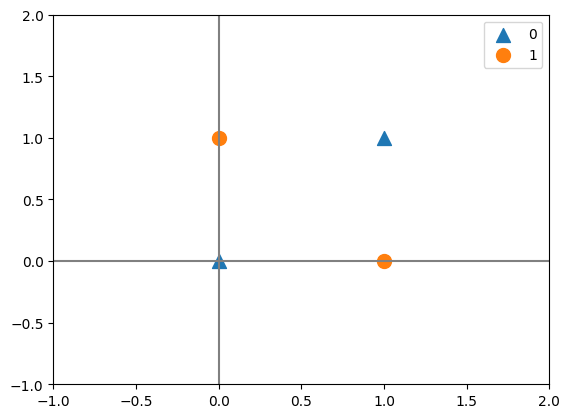

In [56]:
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.hlines(y=0,xmin=-5,xmax=5,colors='gray')
plt.vlines(x=0,ymin=-5,ymax=5,colors='gray')
plt.scatter(x=[0,1],y=[0,1],marker='^',s=100,label='0')
plt.scatter(x=[0,1],y=[1,0],marker='o',s=100,label='1')
plt.legend(loc='best')


* 上の図で、三角(出力が0)と丸(出力が1)を分ける直線が引けない

### 多層パーセプトロン
* パーセプトロンを組み合わせることで非線形の分離を実装可能  

In [63]:
def XOR(x1,x2):
    s1 = OR(x1,x2)
    s2 = NAND(x1,x2)
    y = AND(s1,s2)
    return y

print('XOR')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> AND:{AND(m,n)}, NAND:{NAND(m,n)}, OR:{OR(m,n)}, XOR:{XOR(m,n)}')

XOR
[0, 0] -> AND:0, NAND:1, OR:0, XOR:0
[0, 1] -> AND:0, NAND:1, OR:1, XOR:1
[1, 0] -> AND:0, NAND:1, OR:1, XOR:1
[1, 1] -> AND:1, NAND:0, OR:1, XOR:0


* 線型なパーセプトロンでも多層にすることで非線形な表現が可能。
* でも今のところ、パラメータ(重みやバイアス)の値は人間が期待する出力に合わせて調整している
* 最適なパラメータをデータから学習させることを考える

### ニューラルネットワーク

$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$
を、以下のように変換する  

$$
a= b + w_1 x_1 + w_2 x_2
$$
$$
h(x) = \left\{
\begin{array}{ll}
0 & x \leqq 0 \\
1 & x > 0
\end{array}
\right.
$$
$$
y = h(a)
$$

$a$ : 入力信号の重み付き和(バイアス含む)を計算  
$h(x)$ : そのニューロンが発火する条件が指定されている**活性化関数**  
$y$ : 入力の重み付き和を活性化関数に引き渡した結果の出力  

* 活性化関数はさまざまな関数たりうるが、パーセプトロンはある閾値で出力が切り替わる**ステップ関数**を活性化関数として採用したNNだと言える
* ニューラルネットワークでは一般的に**シグモイド関数**が使われる  

$$
h(x)=\frac{1}{1+\exp(-x)}
$$

* ステップ関数とシグモイド関数を比較

In [72]:
def step_function(x:np.array):
    y = x > 0
    return y.astype(int)
def sigmoid(x:np.array):
    y = 1/(1+np.exp(-x))
    return y

In [70]:
x = np.array([1,0,.5,1.4,50])
step_function(x)

array([1, 0, 1, 1, 1])

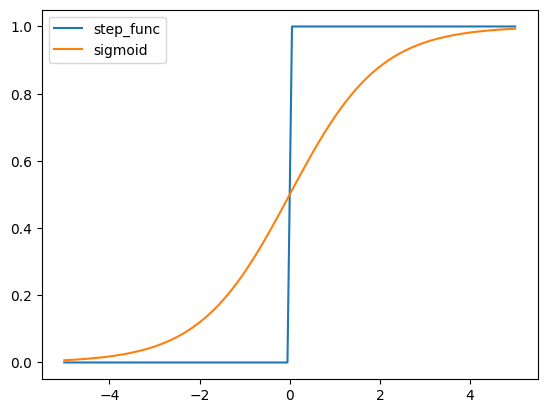

In [76]:
x=np.linspace(-5,5,100)
y_step=step_function(x)
y_sig=sigmoid(x)
plt.plot(x,y_step,label='step_func')
plt.plot(x,y_sig, label = 'sigmoid')
plt.legend(loc ='best')